# **Set-Up**

In [1]:
%pip install torchio --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.3/194.3 kB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import torchio as tio 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import pydicom

import math
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm
from pathlib import Path
from tqdm import tqdm

%matplotlib inline

# **Pre-Processing**

In [3]:
labels_df = pd.read_csv(
    "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"
)

labels_df = labels_df.groupby("patientId")["Target"].max().reset_index()

print(labels_df["Target"].value_counts())
print(labels_df.info(verbose=True, show_counts=True))

Target
0    20672
1     6012
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   Target     26684 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.1+ KB
None


In [4]:
labels_df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,000924cf-0f8d-42bd-9158-1af53881a557,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,1
3,000fe35a-2649-43d4-b027-e67796d412e0,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,1


## Subjects

In [5]:
ROOT_PATH = Path("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/")
patient_dirs = list(ROOT_PATH.glob("*"))

patient_dirs[0] # debug

PosixPath('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/c3b05294-29be-46e4-8a51-96fd211e4ca5.dcm')

In [6]:
ds = pydicom.dcmread(patient_dirs[0])
img = ds.pixel_array

img.shape

(1024, 1024)

In [7]:
def get_patient_label(patient_path: Path, labels_df: pd.DataFrame) -> int:
    patientID = patient_path.stem
    label = labels_df.loc[labels_df["patientId"] == patientID, "Target"]
    label = label.iloc[0] if not label.empty else None
    return int(label)

In [8]:
subjects = []
heights = []
widths = []
labels = []

for subject_path in tqdm(patient_dirs):
    
    img_path = subject_path
    label = get_patient_label(subject_path, labels_df)

    ct = tio.ScalarImage(img_path)
    h, w, _ = ct.spatial_shape   

    subject = tio.Subject(
        CT = ct,
        Label = torch.tensor(label, dtype=torch.long),
        PatientID = subject_path.stem
    )

    subjects.append(subject)
    heights.append(h)
    widths.append(w)
    labels.append(label)

100%|██████████| 26684/26684 [06:52<00:00, 64.76it/s]


In [9]:
print(type(subjects[15]["CT"]), subjects[15]["CT"])
print(type(subjects[15]["Label"]), subjects[15]["Label"])
subjects[15]["CT"].spatial_shape

<class 'torchio.data.image.ScalarImage'> ScalarImage(shape: (1, 1024, 1024, 1); spacing: (0.17, 0.17, 1.00); orientation: LPS+; path: "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/7625412b-fbb0-46d7-9f7d-00b436cc467a.dcm")
<class 'torch.Tensor'> tensor(1)


(1024, 1024, 1)

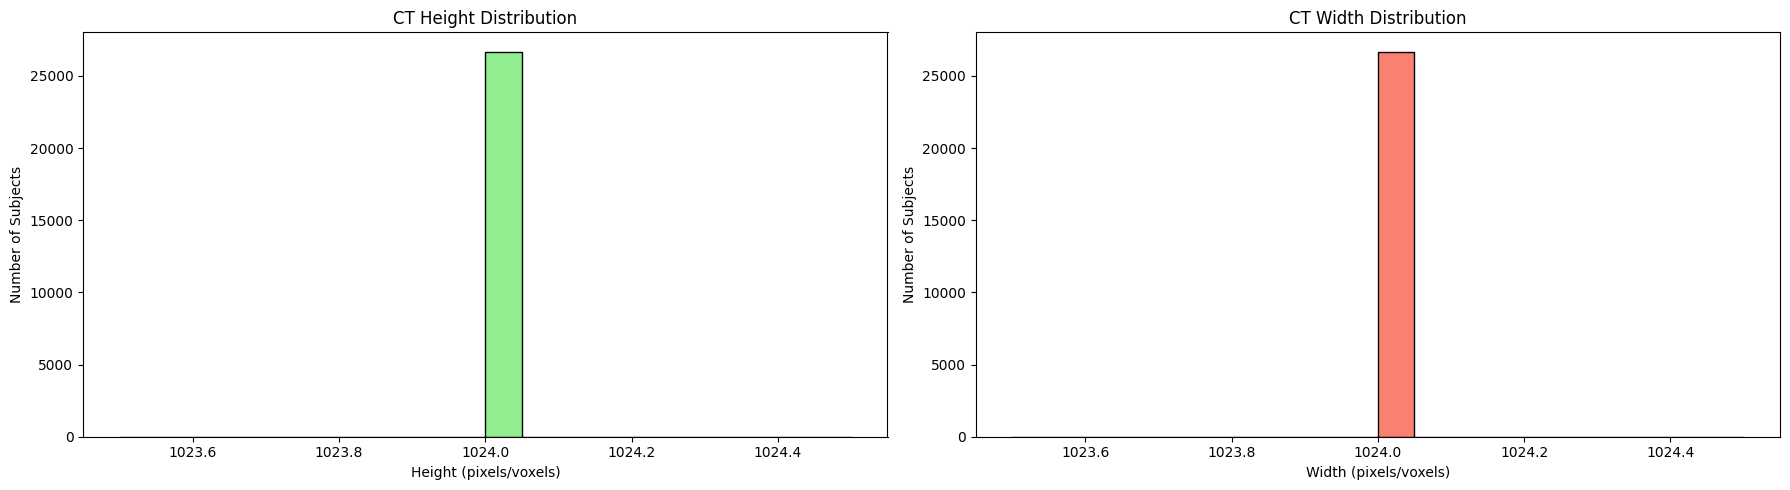

In [10]:
# Plot depth (dimensions)
plt.figure(figsize=(18,5))

# Plot height
plt.subplot(1,2,1)
plt.hist(heights, bins=20, color='lightgreen', edgecolor='black')
plt.title("CT Height Distribution")
plt.xlabel("Height (pixels/voxels)")
plt.ylabel("Number of Subjects")

# Plot width
plt.subplot(1,2,2)
plt.hist(widths, bins=20, color='salmon', edgecolor='black')
plt.title("CT Width Distribution")
plt.xlabel("Width (pixels/voxels)")
plt.ylabel("Number of Subjects")

plt.tight_layout()
plt.show()

In [11]:
img_size_og = subjects[15]["CT"].spatial_shape[0]

## **Transforms**

In [12]:
process = tio.Compose([
    tio.ToCanonical(),                        # step 1: fix orientation - RAS              
    tio.RescaleIntensity((0, 1)),                      # step 2: normalize intensity
    tio.Resize((356, 356, 1)),
    tio.CropOrPad((256, 256, 1)),          
])

augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))

train_transform = tio.Compose([process, augmentation])
val_transform = tio.Compose([process])

## **DataSet & DataLoader**

In [13]:
from sklearn.model_selection import train_test_split

# (90/10)
train_val_subjects, test_subjects = train_test_split(
    subjects,
    test_size=0.15,
    stratify=labels,
    random_state=42
)

# (80/20)
train_subjects, val_subjects = train_test_split(
    train_val_subjects,
    test_size=0.2,
    stratify=[s.Label.item() for s in train_val_subjects],
    random_state=42
)

# Verify class distributions
train_labels = [s.Label.item() for s in train_subjects]
val_labels   = [s.Label.item() for s in val_subjects]
test_labels  = [s.Label.item() for s in test_subjects]

print("Train counts:", np.bincount(train_labels))
print("Val counts:", np.bincount(val_labels))
print("Test counts:", np.bincount(test_labels))

Train counts: [14056  4088]
Val counts: [3515 1022]
Test counts: [3101  902]


In [14]:
train_dataset = tio.SubjectsDataset(train_subjects, transform = train_transform) 
val_dataset = tio.SubjectsDataset(val_subjects, transform = val_transform)  
test_dataset = tio.SubjectsDataset(test_subjects, transform = val_transform)  

In [15]:
from typing import Tuple, List

def collate_subjects(batch: List) -> Tuple[torch.Tensor, torch.Tensor]:
    images = torch.stack([s.CT.data.squeeze(-1) for s in batch])
    labels = torch.tensor([s.Label.item() for s in batch])
    return images, labels

In [16]:
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=4, collate_fn=collate_subjects, shuffle=True, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=4, collate_fn=collate_subjects)
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=4, collate_fn=collate_subjects)

In [17]:
x, y = next(iter(train_loader))
print(f"Images shape fresh off the loader: {x.shape}")
print(f"Labels shape fresh off the loader: {y.shape}")
print(f"Labels corresponding to {y.shape[0]} images in the batch: " + str(y))

Images shape fresh off the loader: torch.Size([128, 1, 256, 256])
Labels shape fresh off the loader: torch.Size([128])
Labels corresponding to 128 images in the batch: tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0])


# **Model**

In [18]:
img_size = x.shape[2]
print(f"Image size fresh off the loader: {img_size}")

channels_in = x.shape[1]
print(f"Input Channels: {channels_in}")

num_classes = 1
print(f"Output Channels: {num_classes}")

learning_rate = 3e-4

Image size fresh off the loader: 256
Input Channels: 1
Output Channels: 1


In [19]:
import torchvision.models as models

model = models.regnet_y_400mf(pretrained=True)

model.stem[0] = nn.Conv2d(1, model.stem[0].out_channels, kernel_size=3, stride=2, padding=1, bias=False)

model.fc = nn.Linear(model.fc.in_features, 1)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-c65dace8.pth


100%|██████████| 16.8M/16.8M [00:00<00:00, 178MB/s]


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
model.to(device);

# **Train**

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss()

In [23]:
# print(model)
x = torch.randn(8, 1, 256, 256).to(device)
y = model(x)
print(y.shape)
print(f"How likely (logits) the model predicts each image in the batch to be pneumonic: \n{y}")
# y.argmax(dim=0)

torch.Size([8, 1])
How likely (logits) the model predicts each image in the batch to be pneumonic: 
tensor([[ 0.3204],
        [-0.7058],
        [ 0.1945],
        [-0.2989],
        [-0.6662],
        [ 0.1537],
        [ 0.1065],
        [ 0.0261]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [24]:
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 3903009 (Approximately 3 Million) Parameters!


In [25]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import time

In [26]:
def validate(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # (B,1)

            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long()

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu().long())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    val_acc = accuracy_score(
        all_labels.numpy(),
        all_preds.numpy()
    ) * 100

    return val_acc

In [27]:
epochs = 30

patience = 5
tolerance = 0.005

best_val_acc = 0.0
stale_epochs = 0

print("Training started...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    START = time.time()
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        labels = labels.float().unsqueeze(1)  # (B,1)

        optimizer.zero_grad()
        logits = model(images)                 # (B,1)
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # --- compute predictions ---
        probs = torch.sigmoid(logits)          # (B,1)
        preds = (probs > 0.5).long()           # binary 0/1
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu().long())

    TRAIN_TIME = time.time()
    # --- epoch metrics ---
    all_preds_tensor = torch.cat(all_preds, dim=0)
    all_labels_tensor = torch.cat(all_labels, dim=0)

    epoch_acc = accuracy_score(all_labels_tensor.numpy(), all_preds_tensor.numpy()) * 100

    # ---- validation ----
    val_acc = validate(model, val_loader, device)
    VAL_TIME = time.time()

    print(
        f"===> Epoch {epoch+1}: "
        f"Loss = {total_loss:.4f} | "
        f"Epoch Acc = {epoch_acc:.2f}% | "
        f"Val Acc = {val_acc:.2f}%"
    )

    # ---- early stopping ----
    if val_acc > best_val_acc + tolerance:
        best_val_acc = val_acc
        stale_epochs = 0

        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": best_val_acc,
                "loss": total_loss,
            },
            "best_model.pth"
        )
    
        print(f"Validation improved to {best_val_acc:.2f}%")
    else:
        stale_epochs += 1
        print(f"No significant improvement ({stale_epochs}/{patience})")

    if stale_epochs >= patience:
        print("Early stopping triggered.")
        break

    print(f"Train time: {int((TRAIN_TIME - START)/60.0)}.{int((TRAIN_TIME - START)%60.0)} mins | Val time: {int((VAL_TIME - TRAIN_TIME)/60.0)}.{int((VAL_TIME - TRAIN_TIME)%60.0)} mins")

Training started...
===> Epoch 1: Loss = 58.4517 | Epoch Acc = 80.89% | Val Acc = 82.90%
Validation improved to 82.90%
Train time: 7.2 mins | Val time: 1.38 mins
===> Epoch 2: Loss = 52.9745 | Epoch Acc = 83.28% | Val Acc = 82.35%
No significant improvement (1/5)
Train time: 7.36 mins | Val time: 1.42 mins
===> Epoch 3: Loss = 50.5194 | Epoch Acc = 83.86% | Val Acc = 83.23%
Validation improved to 83.23%
Train time: 7.23 mins | Val time: 1.40 mins
===> Epoch 4: Loss = 48.4342 | Epoch Acc = 84.56% | Val Acc = 83.09%
No significant improvement (1/5)
Train time: 7.25 mins | Val time: 1.40 mins
===> Epoch 5: Loss = 47.1159 | Epoch Acc = 85.18% | Val Acc = 83.78%
Validation improved to 83.78%
Train time: 7.37 mins | Val time: 1.40 mins
===> Epoch 6: Loss = 45.3514 | Epoch Acc = 85.51% | Val Acc = 83.05%
No significant improvement (1/5)
Train time: 7.14 mins | Val time: 1.42 mins
===> Epoch 7: Loss = 43.4193 | Epoch Acc = 86.50% | Val Acc = 82.28%
No significant improvement (2/5)
Train time: 

# **Evaluate**

In [28]:
checkpoint = torch.load("/kaggle/working/best_model.pth", map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [29]:
model.eval()
all_preds, all_labels, all_probs = [], [], []
val_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)   # (B,1)

        logits = model(images)                 # (B,1)
        loss = criterion(logits, labels)
        val_loss += loss.item()

        probs = torch.sigmoid(logits)          
        preds = (probs > 0.5).long()           

        all_probs.append(probs.cpu().view(-1))     # (B,)
        all_preds.append(preds.cpu().view(-1))     # (B,)
        all_labels.append(labels.cpu().view(-1))   # (B,)

# concatenate
all_probs = torch.cat(all_probs).numpy()
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# accuracy
val_acc = accuracy_score(all_labels, all_preds) * 100
print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.2f}%")

# ROC + AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

Validation Loss: 11.6782 | Validation Accuracy: 83.26%


| Goal                            | TPR (sensitivity) | FPR (1-specificity) |
| ------------------------------- | ----------------- | ------------------- |
| Early detection / screening     | High              | Can be higher       |
| Avoid unnecessary interventions | Moderate          | Low                 |

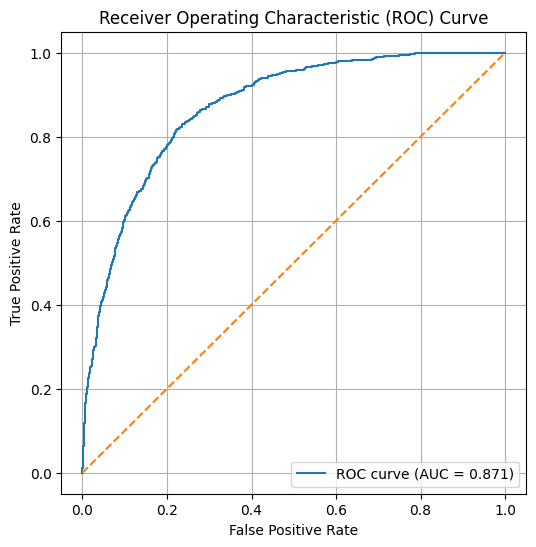

In [30]:
idx_tpr = np.argmax(tpr)
idx_fpr = np.argmin(fpr)

idx = idx_tpr
# best_thresh = thresholds[idx]

# print(f"TPR = {tpr[idx]:.2f} | FPR: {fpr[idx]:.2f}")
# print(f"Best Threshold Value: {best_thresh:.2f}")

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()